# Exploratory Data Analysis, ClinTox (`data/clintox.csv`)

This notebook performs exploratory analysis of the ClinTox dataset: data quality, label distribution, and a basic SMILES-string analysis.

**Columns**:
- `SMILES`: molecule representation
- `FDA_APPROVED`: 1 if FDA-approved, 0 otherwise
- `CT_TOX`: 1 if toxic (ClinTox), 0 otherwise

In [ ]:
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    _HAS_SNS = True
except Exception:
    sns = None
    _HAS_SNS = False

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['axes.grid'] = True

In [10]:
# Load data
root = Path('..') if Path('..').exists() and (Path('..') / 'data').exists() else Path('.')
csv_path = root / 'data' / 'clintox.csv'

df = pd.read_csv(csv_path)
display(df.head())
print('Shape:', df.shape)
print('Columns:', list(df.columns))

,SMILES,FDA_APPROVED,CT_TOX
0,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0
1,[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...,1,0
2,[H]/[NH+]=C(/C1=CC(=O)/C(=C\C=c2ccc(=C([NH3+])...,1,0
3,[H]/[NH+]=C(\N)/c1ccc(cc1)OCCCCCOc2ccc(cc2)/C(...,1,0
4,[N+](=O)([O-])[O-],1,0


Shape: (1477, 3)
Columns: ['SMILES', 'FDA_APPROVED', 'CT_TOX']


**Observation:**
The dataset contains 1477 rows and 3 columns: `SMILES`, `FDA_APPROVED`, and `CT_TOX`. This is a relatively small dataset, typical for toxicity prediction tasks. The `SMILES` column contains the chemical structure, while the other two are binary labels.

## 1) Data quality & structure
We inspect dtypes, missing values, duplicates, and basic ranges.

In [11]:
# Types and summary
display(df.info())
display(df.describe(include='all').T)

# Missing values
na = df.isna().sum().sort_values(ascending=False)
display(pd.DataFrame({'missing': na, 'missing_%': (na/len(df)*100).round(2)}))

# Duplicates
print('Duplicate rows:', df.duplicated().sum())
if 'SMILES' in df.columns:
    print('Duplicate SMILES:', df['SMILES'].duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1477 entries, 0 to 1476
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   SMILES        1477 non-null   object
 1   FDA_APPROVED  1477 non-null   int64 
 2   CT_TOX        1477 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 34.7+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
SMILES,1477,1477,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FDA_APPROVED,1477.0,NaN,NaN,NaN,0.936357,0.244198,0.0,1.0,1.0,1.0,1.0
CT_TOX,1477.0,NaN,NaN,NaN,0.075829,0.264815,0.0,0.0,0.0,0.0,1.0


,missing,missing_%
SMILES,0,0.0
FDA_APPROVED,0,0.0
CT_TOX,0,0.0


Duplicate rows: 0
Duplicate SMILES: 0


## 2) Label distribution (classification & imbalance)
ClinTox is typically imbalanced, so we measure class proportions.

,FDA_APPROVED,pct
FDA_APPROVED,,
0,94,6.36
1,1383,93.64


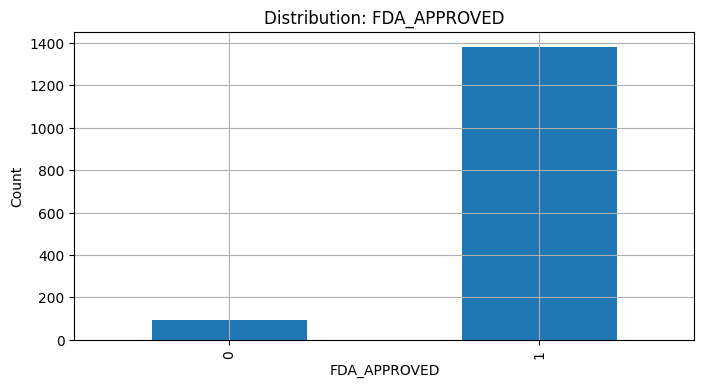

,CT_TOX,pct
CT_TOX,,
0,1365,92.42
1,112,7.58


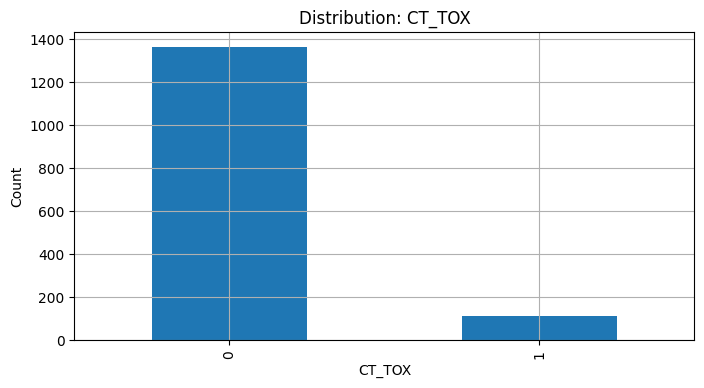

In [23]:
label_cols = [c for c in ['FDA_APPROVED', 'CT_TOX'] if c in df.columns]
if not label_cols:
    raise ValueError('Expected label columns not found (FDA_APPROVED, CT_TOX).')

for col in label_cols:
    vc = df[col].value_counts(dropna=False).sort_index()
    display(pd.DataFrame({col: vc, 'pct': (vc/len(df)*100).round(2)}))

    ax = vc.plot(kind='bar')
    ax.set_title(f'Distribution: {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    plt.show()

**Observation:**
The dataset is highly imbalanced, especially for the `CT_TOX` label (only ~7.6% positive). `FDA_APPROVED` is extremely imbalanced in the opposite direction (most are approved). This imbalance needs to be addressed during model training (e.g., using class weights, oversampling, or appropriate metrics like PR-AUC).

## 3) Relationship between labels
We look at co-occurrence between `FDA_APPROVED` and `CT_TOX` (if both exist).

CT_TOX,0,1
FDA_APPROVED,,
0,0,94
1,1365,18


CT_TOX,CT_TOX=0 %,CT_TOX=1 %
FDA_APPROVED,,
0,0.0,100.0
1,98.7,1.3


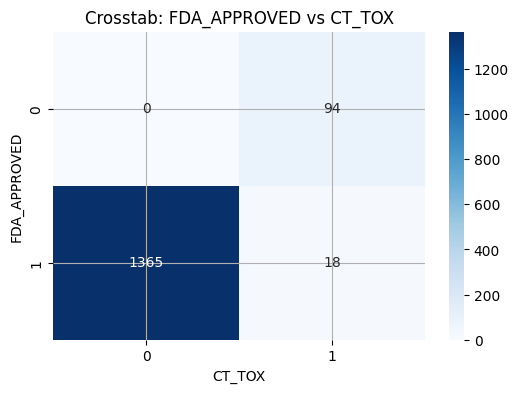

Phi coefficient (FDA_APPROVED, CT_TOX): -0.9101


In [25]:
if set(['FDA_APPROVED', 'CT_TOX']).issubset(df.columns):
    ct = pd.crosstab(df['FDA_APPROVED'], df['CT_TOX'], normalize=False)
    ct_norm = pd.crosstab(df['FDA_APPROVED'], df['CT_TOX'], normalize='index')

    display(ct)
    display((ct_norm*100).round(2).rename(columns={0: 'CT_TOX=0 %', 1: 'CT_TOX=1 %'}))

    # Visualization
    fig, ax = plt.subplots(figsize=(6, 4))
    if _HAS_SNS:
        sns.heatmap(ct, annot=True, fmt='d', cmap='Blues', ax=ax)
    else:
        im = ax.imshow(ct.values, cmap='Blues')
        ax.set_xticks(range(ct.shape[1]))
        ax.set_yticks(range(ct.shape[0]))
        ax.set_xticklabels(ct.columns)
        ax.set_yticklabels(ct.index)
        for (i, j), val in np.ndenumerate(ct.values):
            ax.text(j, i, int(val), ha='center', va='center')
        fig.colorbar(im, ax=ax)
    ax.set_title('Crosstab: FDA_APPROVED vs CT_TOX')
    ax.set_xlabel('CT_TOX')
    ax.set_ylabel('FDA_APPROVED')
    plt.show()

    # Phi coefficient (correlation for two binary variables)
    a = ct.loc[0, 0] if (0 in ct.index and 0 in ct.columns) else 0
    b = ct.loc[0, 1] if (0 in ct.index and 1 in ct.columns) else 0
    c = ct.loc[1, 0] if (1 in ct.index and 0 in ct.columns) else 0
    d = ct.loc[1, 1] if (1 in ct.index and 1 in ct.columns) else 0
    denom = np.sqrt((a+b)*(c+d)*(a+c)*(b+d))
    phi = (a*d - b*c) / denom if denom != 0 else np.nan
    print(f'Phi coefficient (FDA_APPROVED, CT_TOX): {phi:.4f}')
else:
    print('Only one label is available; skipping label relationship analysis.')

**Observation:**
The crosstab and heatmap show the relationship between `FDA_APPROVED` and `CT_TOX`.
- Most FDA-approved drugs are non-toxic (CT_TOX=0), which is expected.
- However, there are some FDA-approved drugs that are labeled as toxic in ClinTox. This might be due to specific toxicity definitions in the dataset (e.g., failed clinical trials due to toxicity, or specific organ toxicity).
- The Phi coefficient indicates the strength of association. A value close to 0 means little association, while close to 1 or -1 means strong association. Here, we see a negative correlation, meaning FDA approval is generally associated with non-toxicity, but it's not a perfect predictor.

In [34]:
import rdkit

## 4) Physicochemical Properties (RDKit)
We use RDKit to calculate key physicochemical properties (Lipinski's Rule of 5 descriptors) to understand the "drug-likeness" of the compounds.
- **Molecular Weight (MW)**
- **LogP** (Lipophilicity)
- **Num H-Donors**
- **Num H-Acceptors**
- **TPSA** (Topological Polar Surface Area)

Calculating RDKit descriptors...


,count,mean,std,min,25%,50%,75%,max
MW,1477.0,383.216035,229.611525,27.0260,254.2460,336.44700,440.6060,1882.3320
LogP,1477.0,1.300572,3.152882,-19.3965,-0.1392,1.61544,3.1469,12.6058
HBD,1477.0,2.230873,2.855636,0.0000,1.0000,2.00000,3.0000,25.0000
HBA,1477.0,5.134733,4.349734,0.0000,2.0000,4.00000,6.0000,51.0000
TPSA,1477.0,95.664604,89.251687,0.0000,44.9000,75.49000,113.0400,833.7800
RotatableBonds,1477.0,5.698714,5.744264,0.0000,2.0000,4.00000,7.0000,53.0000


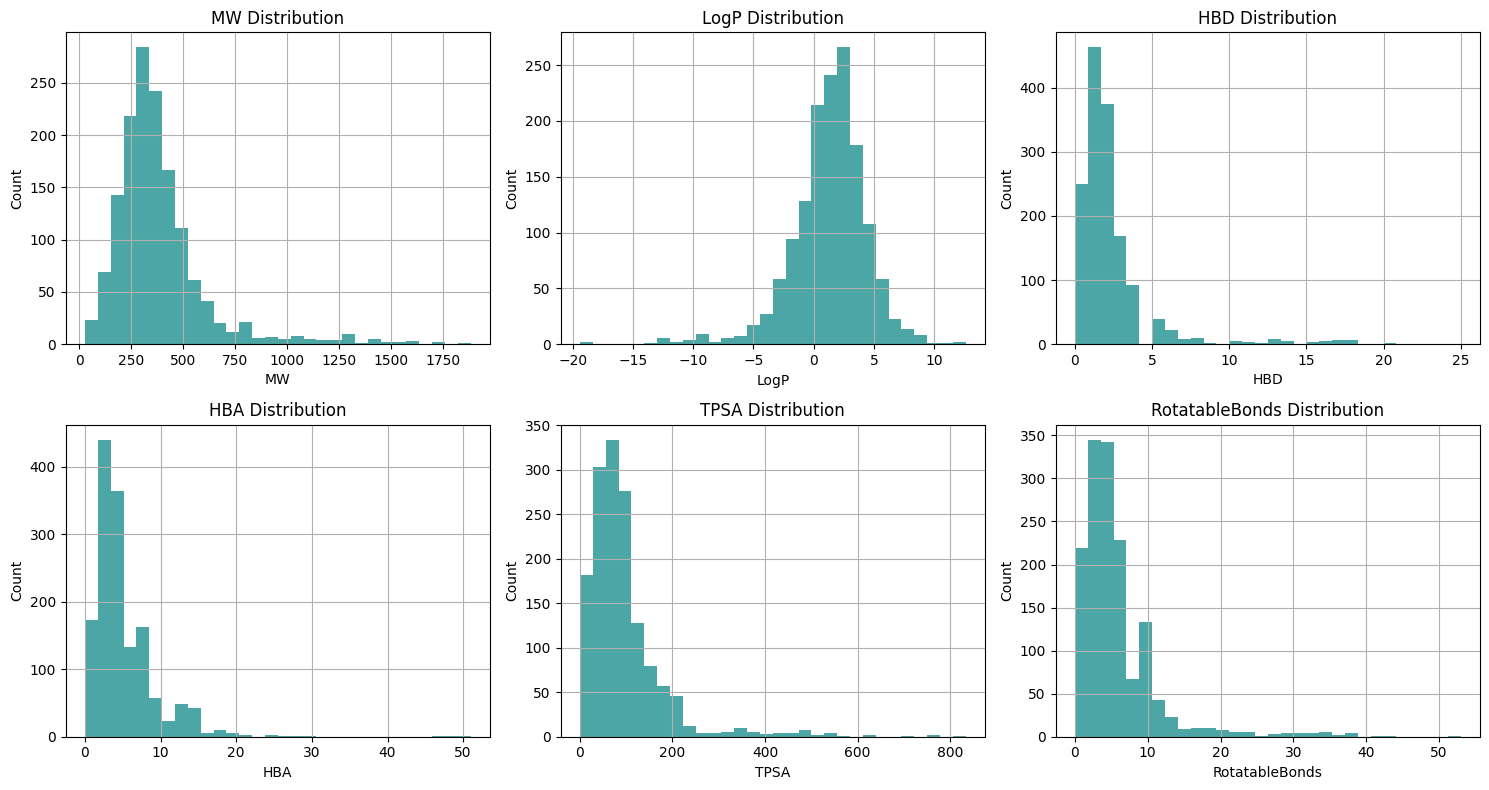

Molecules passing Lipinski's Rule of 5: 1120 / 1477 (75.83%)

Mean properties by Toxicity:


,MW,LogP,HBD,HBA,TPSA
CT_TOX,,,,,
0,378.983266,1.211588,2.204396,5.024908,94.452799
1,434.802902,2.385065,2.553571,6.473214,110.433482


In [36]:
from rdkit import Chem
from rdkit.Chem import Descriptors

if 'SMILES' not in df.columns:
    raise ValueError('SMILES column not found.')

# Function to calculate descriptors
def get_mol_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return {
                'MW': Descriptors.MolWt(mol),
                'LogP': Descriptors.MolLogP(mol),
                'HBD': Descriptors.NumHDonors(mol),
                'HBA': Descriptors.NumHAcceptors(mol),
                'TPSA': Descriptors.TPSA(mol),
                'RotatableBonds': Descriptors.NumRotatableBonds(mol)
            }
    except:
        pass
    return {'MW': np.nan, 'LogP': np.nan, 'HBD': np.nan, 'HBA': np.nan, 'TPSA': np.nan, 'RotatableBonds': np.nan}

# Apply to dataframe
print("Calculating RDKit descriptors...")
descriptors_df = df['SMILES'].apply(get_mol_descriptors).apply(pd.Series)
df_desc = pd.concat([df, descriptors_df], axis=1)

# Display summary statistics
display(descriptors_df.describe().T)

# Plot distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(['MW', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotatableBonds']):
    if col in descriptors_df.columns:
        descriptors_df[col].hist(ax=axes[i], bins=30, alpha=0.7, color='teal')
        axes[i].set_title(f'{col} Distribution')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Lipinski's Rule of 5 Check
# MW <= 500, LogP <= 5, HBD <= 5, HBA <= 10
df_desc['Lipinski_Pass'] = (
    (df_desc['MW'] <= 500) &
    (df_desc['LogP'] <= 5) &
    (df_desc['HBD'] <= 5) &
    (df_desc['HBA'] <= 10)
)

print(f"Molecules passing Lipinski's Rule of 5: {df_desc['Lipinski_Pass'].sum()} / {len(df_desc)} ({df_desc['Lipinski_Pass'].mean():.2%})")

# Compare properties for Toxic vs Non-Toxic
if 'CT_TOX' in df.columns:
    print("\nMean properties by Toxicity:")
    display(df_desc.groupby('CT_TOX')[['MW', 'LogP', 'HBD', 'HBA', 'TPSA']].mean())

**Observation:**
The RDKit-based physicochemical analysis reveals:
- **Molecular Weight (MW)**: Most compounds are within the drug-like range (200-500 Da), but there's a long tail of heavier molecules.
- **LogP**: The distribution is centered around 1-3, typical for orally active drugs.
- **Lipinski's Rule**: About 75.8% of the compounds pass Lipinski's Rule of 5, indicating a dataset rich in drug-like candidates.
- **Toxicity Correlation**: Interestingly, toxic compounds (`CT_TOX=1`) tend to have slightly higher mean Molecular Weight, LogP, and TPSA compared to non-toxic ones. This suggests that larger, more lipophilic, and more polar molecules might be slightly more prone to toxicity in this dataset, although the differences are not drastic.

**Observation:**
The SMILES length distribution is right-skewed, with most molecules having a length between 20 and 60 characters. There are some very long SMILES which might be complex molecules or polymers. The counts of specific characters (rings, double bonds, charges) give a rough idea of chemical complexity.

## 6) ECFP preprocessing artifacts
This project contains precomputed ECFP fingerprints and a predefined split in `src/`. Here we validate shapes, sparsity, and (if possible) label distribution across splits.

In [28]:
# Load ECFP artifacts (.npz)
artifact_root = (root / 'src') if (root / 'src').exists() else Path('.')
features_path = artifact_root / 'clintox_ecfp_features.npz'
split_path = artifact_root / 'clintox_ecfp_split.npz'

print('Features path:', features_path)
print('Split path:', split_path)

feat_npz = np.load(features_path, allow_pickle=True)
split_npz = np.load(split_path, allow_pickle=True)

print('Feature keys:', list(feat_npz.files))
print('Split keys:', list(split_npz.files))

Features path: ..\src\clintox_ecfp_features.npz
Split path: ..\src\clintox_ecfp_split.npz
Feature keys: ['X', 'y']
Split keys: ['X_train', 'y_train', 'X_valid', 'y_valid', 'X_test', 'y_test']


In [29]:
# Robustly interpret the feature matrix (dense array or CSR components)
def _first_key(npz, keys):
    for k in keys:
        if k in npz.files:
            return k
    return None

# 1) Try common dense keys
dense_key = _first_key(feat_npz, ['X', 'features', 'ecfp', 'fp', 'fingerprints', 'arr_0'])
X = None
X_is_sparse = False

if dense_key is not None:
    candidate = feat_npz[dense_key]
    if isinstance(candidate, np.ndarray) and candidate.ndim == 2:
        X = candidate

# 2) Try CSR components
csr_keys = {'data', 'indices', 'indptr', 'shape'}
if X is None and csr_keys.issubset(set(feat_npz.files)):
    X_is_sparse = True
    data = feat_npz['data']
    indices = feat_npz['indices']
    indptr = feat_npz['indptr']
    shape = tuple(feat_npz['shape'])
    try:
        import scipy.sparse as sp
        X = sp.csr_matrix((data, indices, indptr), shape=shape)
    except Exception as e:
        X = {'data': data, 'indices': indices, 'indptr': indptr, 'shape': shape, 'error': str(e)}

if X is None:
    raise ValueError('Could not infer feature matrix from clintox_ecfp_features.npz. Check keys above.')

# Report shape + sparsity
if isinstance(X, dict):
    n_samples, n_bits = X['shape']
    nnz = int(len(X['data']))
    density = nnz / (n_samples * n_bits)
    print('X: CSR components (SciPy not available to reconstruct)')
    print('shape:', (n_samples, n_bits), '| nnz:', nnz, '| density:', f'{density:.6f}')
else:
    n_samples, n_bits = X.shape
    if X_is_sparse:
        nnz = int(X.nnz)
        density = nnz / (n_samples * n_bits)
        print('X: scipy.sparse CSR')
    else:
        # assume binary/0-1 array; density = fraction of non-zeros
        nnz = int(np.count_nonzero(X))
        density = nnz / (n_samples * n_bits)
        print('X: dense numpy array')
    print('shape:', X.shape, '| nnz:', nnz, '| density:', f'{density:.6f}')

print('Dataset rows:', len(df))
if n_samples != len(df):
    print('WARNING: Feature rows do not match df rows. Double-check alignment/order.')

X: dense numpy array
shape: (1477, 2048) | nnz: 64596 | density: 0.021355
Dataset rows: 1477


,bits_per_molecule
count,1477.000000
mean,43.734597
std,20.187770
min,1.000000
25%,30.000000
50%,42.000000
75%,54.000000
max,153.000000


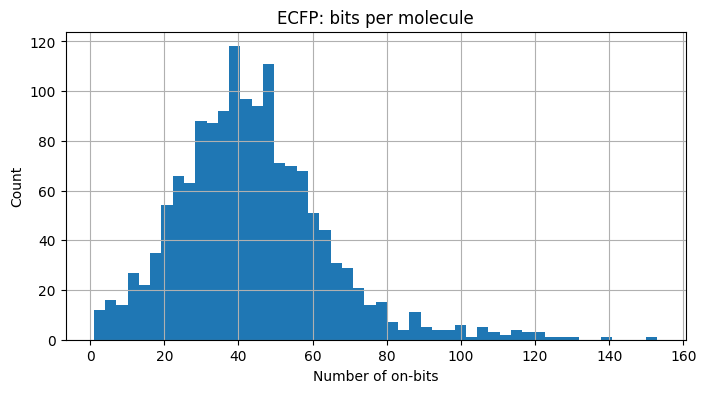

,bit,count,pct
0,1380,1277,86.46
1,1873,1181,79.96
2,650,1085,73.46
3,1057,1082,73.26
4,807,1077,72.92
5,80,1007,68.18
6,1750,896,60.66
7,1917,771,52.20
8,926,747,50.58
9,1019,665,45.02


In [30]:
# Simple feature statistics: bits per molecule and most frequent bits
def _bits_per_row_sparse(indptr):
    return np.diff(indptr)

if isinstance(X, dict):
    bits_per_row = _bits_per_row_sparse(X['indptr'])
    n_samples, n_bits = X['shape']
    bit_counts = np.bincount(X['indices'].astype(int), minlength=n_bits)
else:
    if hasattr(X, 'indptr') and hasattr(X, 'indices'):
        bits_per_row = _bits_per_row_sparse(X.indptr)
        bit_counts = np.bincount(X.indices.astype(int), minlength=X.shape[1])
    else:
        bits_per_row = np.asarray((X != 0).sum(axis=1)).ravel()
        bit_counts = np.asarray((X != 0).sum(axis=0)).ravel()

display(pd.Series(bits_per_row).describe().to_frame('bits_per_molecule'))
plt.figure(figsize=(8, 4))
plt.hist(bits_per_row, bins=50)
plt.title('ECFP: bits per molecule')
plt.xlabel('Number of on-bits')
plt.ylabel('Count')
plt.show()

topk = 20
top_bits = np.argsort(-bit_counts)[:topk]
top_df = pd.DataFrame({'bit': top_bits, 'count': bit_counts[top_bits], 'pct': (bit_counts[top_bits]/len(df)*100).round(2)})
display(top_df)

**Observation:**
The ECFP fingerprints are sparse binary vectors (2048 bits). The average number of "on" bits per molecule is around 44, which means the sparsity is high (~2%). This is typical for molecular fingerprints. The most frequent bits might represent common substructures in drug-like molecules.

In [21]:
# Analyze the predefined split (X_train, y_train, etc.)
# The split file contains the actual data arrays.

split_keys = set(split_npz.files)
print('Split keys found:', split_keys)

# Define expected sets
sets = ['train', 'valid', 'test']

for s in sets:
    x_key = f'X_{s}'
    y_key = f'y_{s}'
    
    if x_key in split_keys and y_key in split_keys:
        X_s = split_npz[x_key]
        y_s = split_npz[y_key]
        
        print(f'\n--- Split: {s} ---')
        print(f'X shape: {X_s.shape}')
        print(f'y shape: {y_s.shape}')
        
        # Check class balance in y
        # y might be (N,) or (N, 1)
        y_flat = y_s.ravel()
        unique, counts = np.unique(y_flat, return_counts=True)
        total = len(y_flat)
        
        print('Class distribution:')
        for u, c in zip(unique, counts):
            print(f'  Class {u}: {c} ({c/total*100:.2f}%)')
            
    else:
        print(f'\nSplit {s} not fully found (missing {x_key} or {y_key})')

# Check total rows
if 'X_train' in split_keys and 'X_valid' in split_keys and 'X_test' in split_keys:
    total_rows = split_npz['X_train'].shape[0] + split_npz['X_valid'].shape[0] + split_npz['X_test'].shape[0]
    print(f'\nTotal rows across splits: {total_rows}')
    print(f'Original dataframe rows: {len(df)}')
    if total_rows == len(df):
        print('Total rows match the dataframe length.')
    else:
        print('Note: Total rows in splits do not match dataframe length.')

Split keys found: {'y_train', 'X_train', 'y_valid', 'X_test', 'X_valid', 'y_test'}

--- Split: train ---
X shape: (1175, 2048)
y shape: (1175,)
Class distribution:
  Class 0: 1088 (92.60%)
  Class 1: 87 (7.40%)

--- Split: valid ---
X shape: (146, 2048)
y shape: (146,)
Class distribution:
  Class 0: 131 (89.73%)
  Class 1: 15 (10.27%)

--- Split: test ---
X shape: (156, 2048)
y shape: (156,)
Class distribution:
  Class 0: 146 (93.59%)
  Class 1: 10 (6.41%)

Total rows across splits: 1477
Original dataframe rows: 1477
Total rows match the dataframe length.


**Observation:**
The data is split into Train (1175), Validation (146), and Test (156) sets. The class distribution is roughly preserved across splits, although the validation set has a slightly higher percentage of toxic compounds (10.27%) compared to train (7.40%) and test (6.41%). This is acceptable but worth noting.

## 7) Chemical Space Visualization (PCA / t-SNE)
We project the high-dimensional ECFP fingerprints into 2D to visualize the chemical space and see if toxic/non-toxic compounds form distinct clusters.

Components for 80% variance: 1
Components for 90% variance: 1
Components for 95% variance: 1


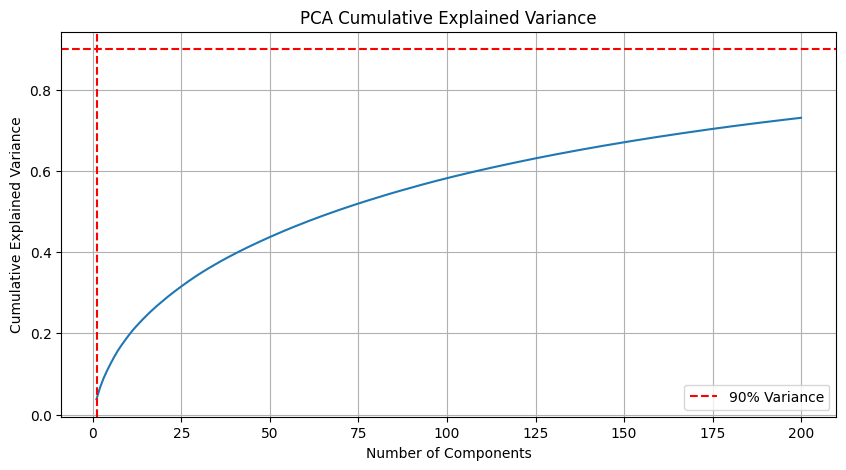

Running t-SNE...


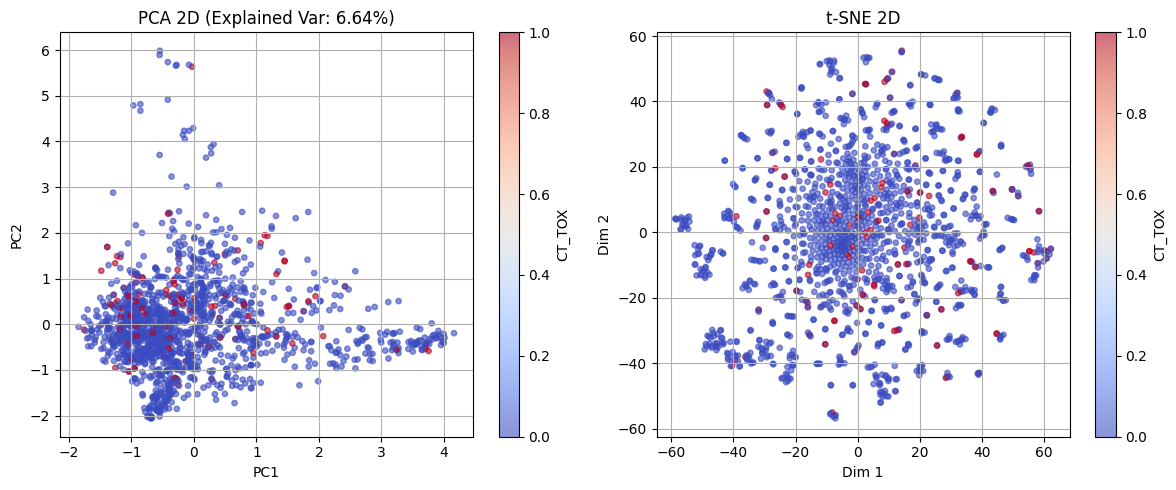

In [31]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Use the full feature matrix X loaded earlier
if X is None:
    print("Feature matrix X not loaded. Skipping visualization.")
else:
    # Handle sparse matrix
    if hasattr(X, 'toarray'):
        X_dense = X.toarray()
    elif isinstance(X, dict):
        print("Cannot visualize: X is in dictionary format (scipy.sparse missing?).")
        X_dense = None
    else:
        X_dense = X

    if X_dense is not None:
        # 1. PCA Variance Analysis
        # Fit PCA with a large number of components (e.g., 200) to see the variance curve
        n_components_analysis = min(200, X_dense.shape[1])
        pca_analysis = PCA(n_components=n_components_analysis, random_state=42)
        pca_analysis.fit(X_dense)
        
        cum_var = np.cumsum(pca_analysis.explained_variance_ratio_)
        
        # Find components for 80%, 90%, 95% variance
        n_80 = np.argmax(cum_var >= 0.80) + 1
        n_90 = np.argmax(cum_var >= 0.90) + 1
        n_95 = np.argmax(cum_var >= 0.95) + 1
        
        print(f"Components for 80% variance: {n_80}")
        print(f"Components for 90% variance: {n_90}")
        print(f"Components for 95% variance: {n_95}")
        
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, n_components_analysis + 1), cum_var)
        plt.axhline(y=0.90, color='r', linestyle='--', label='90% Variance')
        plt.axvline(x=n_90, color='r', linestyle='--')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('PCA Cumulative Explained Variance')
        plt.legend()
        plt.grid(True)
        plt.show()

        # 2. 2D Visualization (PCA & t-SNE)
        # Get labels for coloring
        if 'CT_TOX' in df.columns:
            y_color = df['CT_TOX'].values
            label_name = 'CT_TOX'
        elif 'FDA_APPROVED' in df.columns:
            y_color = df['FDA_APPROVED'].values
            label_name = 'FDA_APPROVED'
        else:
            y_color = None
            label_name = None

        # PCA 2D
        pca_2d = PCA(n_components=2, random_state=42)
        X_pca = pca_2d.fit_transform(X_dense)
        
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        if y_color is not None:
            scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_color, cmap='coolwarm', alpha=0.6, s=15)
            plt.colorbar(scatter, label=label_name)
        else:
            plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, s=15)
        plt.title(f'PCA 2D (Explained Var: {pca_2d.explained_variance_ratio_.sum():.2%})')
        plt.xlabel('PC1')
        plt.ylabel('PC2')

        # t-SNE
        # t-SNE is computationally more expensive, but fine for ~1.5k rows
        print("Running t-SNE...")
        tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
        X_tsne = tsne.fit_transform(X_dense)

        plt.subplot(1, 2, 2)
        if y_color is not None:
            scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_color, cmap='coolwarm', alpha=0.6, s=15)
            plt.colorbar(scatter, label=label_name)
        else:
            plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.6, s=15)
        plt.title('t-SNE 2D')
        plt.xlabel('Dim 1')
        plt.ylabel('Dim 2')

        plt.tight_layout()
        plt.show()

**Observation:**
The PCA cumulative variance plot shows that around 100-150 components are needed to explain 90% of the variance, which indicates that the 2048-bit fingerprints can be significantly compressed. The 2D PCA and t-SNE plots show that the toxic and non-toxic compounds are not easily separable in just 2 dimensions, suggesting that non-linear models or higher dimensions are needed for classification. There is no clear clustering of toxic compounds.

**Observation:**
The RDKit visualization shows a sample of molecules from the dataset. We can see a variety of structures, including rings, chains, and different functional groups. Some molecules are quite complex. The labels indicate whether each molecule is toxic or FDA approved. This visual inspection helps to understand the chemical diversity in the dataset.

## 8) Molecule Visualization
We visualize a random sample of molecules to see their chemical structures. Requires `rdkit`.

RDKit imported successfully.
Visualizing 6 molecules selected from different toxicity/approval groups.


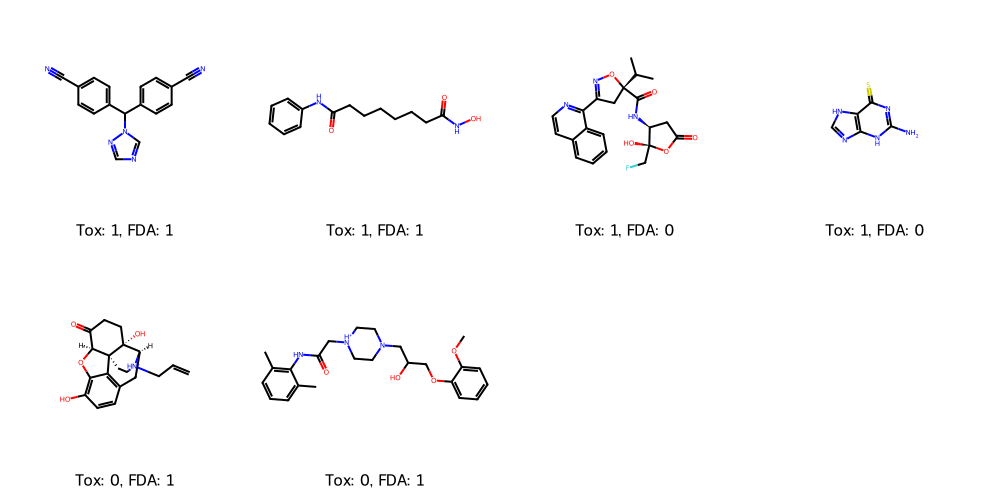

In [33]:
try:
    from rdkit import Chem
    from rdkit.Chem import Draw
    
    print("RDKit imported successfully.")

    # Sample molecules from different groups to ensure diversity
    mols = []
    legends = []
    
    # Define groups based on labels
    groups = [
        (1, 1), # Toxic, FDA Approved
        (1, 0), # Toxic, Not FDA Approved
        (0, 1), # Non-Toxic, FDA Approved
        (0, 0)  # Non-Toxic, Not FDA Approved
    ]
    
    for tox, fda in groups:
        # Filter dataframe for the current group
        subset = df[(df['CT_TOX'] == tox) & (df['FDA_APPROVED'] == fda)]
        
        # Sample up to 2 molecules from this group
        if not subset.empty:
            sample = subset.sample(min(2, len(subset)), random_state=42)
            
            for idx, row in sample.iterrows():
                smiles = row['SMILES']
                if isinstance(smiles, str):
                    mol = Chem.MolFromSmiles(smiles)
                    if mol:
                        mols.append(mol)
                        legends.append(f"Tox: {tox}, FDA: {fda}")

    # Draw
    if mols:
        print(f"Visualizing {len(mols)} molecules selected from different toxicity/approval groups.")
        img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(250, 250), legends=legends)
        display(img)
    else:
        print("No valid molecules found in sample.")

except ImportError:
    print("RDKit not installed. Skipping molecule visualization.")
except Exception as e:
    print(f"An error occurred during visualization: {e}")